# 统计 new structural entropy
## & new distance structural entropy

## 统计  Wikipedia

In [153]:
import pymongo
import matplotlib.pyplot as plt
import numpy as np
from dotenv import dotenv_values
import collections
import pandas as pd
from matplotlib.ticker import FuncFormatter

env_config = dotenv_values("../.env")

In [ ]:
import pandas as pd
# 打开一个 xlsx 文件
XLSX_WRITER = pd.ExcelWriter('new_structural_entropy.xlsx', engine="xlsxwriter")

In [212]:
def draw_xlsx_sheet(sheet_writer, df, sheetTitle, chartTitle,x_axis_label,
                    y_axis_label, x_axis_options={}, y_axis_options={}, graph_size_df=None):
    
    if graph_size_df is not None:
        graph_size_df = graph_size_df.add_suffix('_size')
        df_excel = df.merge(graph_size_df, left_index=True, right_index=True)
        df_excel.to_excel(sheet_writer, sheet_name=sheetTitle, index=True)
    else:
        df.to_excel(sheet_writer, sheet_name=sheetTitle, index=True)

    workbook = sheet_writer.book
    worksheet = sheet_writer.sheets[sheetTitle]

    # 获取数据范围
    num_rows, num_cols = df.shape  # 获取行数和列数
    start_row = 1  # 数据开始的行（Excel 中 A2 行，0 为标题行）
    end_row = start_row + num_rows - 1  # 数据结束行
    category_col  = 0  # 月份列（第 1 列，索引从 0 开始）
    sales_col = 1  # 销售列（第 2 列）

    # 创建折线图
    chart = workbook.add_chart({"type": "line"})
    for col_idx, col_name in enumerate(df.columns, start=1):
        chart.add_series({
            "name":       col_name,  # 图表中的系列名称
            "categories": [sheetTitle, start_row, category_col, end_row, category_col],  # 分类轴为索引
            "values":     [sheetTitle, start_row, col_idx, end_row, col_idx],  # 值列
        })
        
    chart.set_title({"name": chartTitle,"name_font": {"size": 8}})
    x_axis_options['name'] = x_axis_label
    y_axis_options['name'] = y_axis_label
    chart.set_x_axis(x_axis_options)
    chart.set_y_axis(y_axis_options)
    chart.set_size({'width': 600, 'height': 400})
    
    chart.set_legend({'position': 'right',
                      'max_width': 500,
                      'overlay': False,
                      'font': {'size': 8, 'bold': False}
                      })

    # 插入图表
    worksheet.insert_chart("F2", chart)

In [155]:
database_name = f"wikipedia_dump_v{env_config['WIKI_VERSION']}"
wikipedia_entropy_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name]["new_structural_entropy"]
wikipedia_entropy_collection.count_documents({})

66

In [156]:
start_year, end_year = 2004,2024
year_range = np.arange(start_year, end_year+1, dtype=np.int16)


entropy_lv = {
    "degree entropy":np.full(end_year-start_year+1,np.nan),
    'structural entropy':np.full(end_year-start_year+1,np.nan),
    # 'delta':np.full(end_year-start_year+1,np.nan)
}
for lv in range(3,4):
    for doc in wikipedia_entropy_collection.find({'level':lv}):
        index = doc['year'] - start_year
        if index <= 0:
            continue
        entropy_lv['structural entropy'][index] = doc['entropy']['littlestructuralentropy']    
        entropy_lv['degree entropy'][index] = doc['entropy']['bigdegreeentropy']    
        
entropy_lv['KQI'] = entropy_lv['degree entropy'] - entropy_lv['structural entropy']
df = pd.DataFrame(entropy_lv, index=year_range)

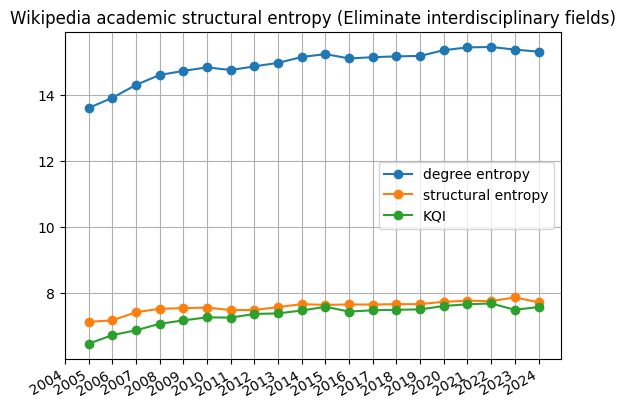

In [157]:
df.plot( marker='o')
# plt.xlim(start_year, end_year)
plt.title("Wikipedia academic structural entropy (Eliminate interdisciplinary fields)")
plt.xticks(year_range)
plt.grid()
plt.gcf().autofmt_xdate()

In [158]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "Wikipedia",
                "Wikipedia academic In-Degree KQI",
                "Year",
                "Entropy", y_axis_options = {'num_format': '#,##0','min':4, 'minor_unit':1},
                )

In [159]:
# df.plot( marker='o')
# # plt.xlim(start_year, end_year)
# plt.title("wikipedia academic structural entropy (Eliminate interdisciplinary fields)")
# plt.xticks(year_range)
# plt.grid()
# plt.gcf().autofmt_xdate()

# openalex

In [160]:
database_name = f"openalex_v{env_config['OPENALEX_VERSION']}"
openalex_entropy_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name]["new_structural_entropy"]
openalex_entropy_collection.count_documents({})

517

In [161]:
start_year, end_year = 1940,2024
year_range = np.arange(start_year, end_year+1, dtype=np.int16)

entropy_data_list = collections.defaultdict(lambda :np.full(end_year-start_year+1,np.nan))
   
for doc in openalex_entropy_collection.find({ 'rankType':'current', 
                                             'startPercent':0, }):
    if isinstance(doc['entropy'],float):
        continue
    
    index = doc['year'] - start_year
    if index < 0:
        continue
    endPercent = doc['endPercent']
    if endPercent not in [10,40, 60,100]:
        continue
    
    key = f"top {endPercent}% degree entropy"
    entropy_data_list[key][index] = doc['entropy']['bigdegreeentropy']
    key = f"top {endPercent}% structural entropy"
    entropy_data_list[key][index] = doc['entropy']['littlestructuralentropy']
    key = f"top {endPercent}% KQI"
    entropy_data_list[key][index] = doc['entropy']['bigdegreeentropy']- doc['entropy']['littlestructuralentropy']

len(entropy_data_list)

12

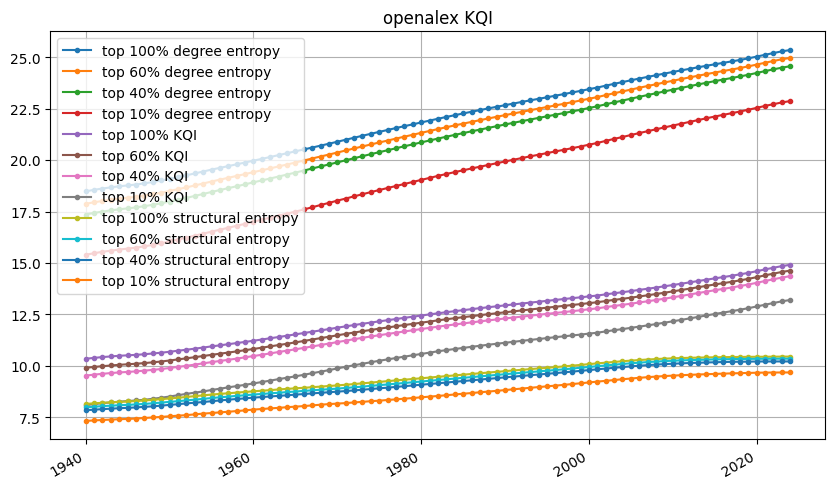

In [162]:
df = pd.DataFrame(entropy_data_list, index=year_range)
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]

# plt.figure(figsize=(22, 10))  # 宽度为 10 英寸，高度为 6 英寸
df.plot(marker=".",figsize=(10, 6))
# plt.xlim(start_year, end_year)
plt.title("openalex KQI")
# plt.xticks(year_range)
plt.grid()
plt.gcf().autofmt_xdate()
plt.show()

In [163]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "OpenAlex",
                "OpenAlex In-Degree KQI",
                "Year",
                "Entropy", y_axis_options = {'num_format': '#,##0','min':4, 'minor_unit':1},
                )

# OpenAlex sub discipline

In [164]:
database_name = f"openalex_v{env_config['OPENALEX_VERSION']}"
openalex_entropy_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name]["new_structural_entropy_subdiscipline"]
openalex_entropy_collection.count_documents({})

2559

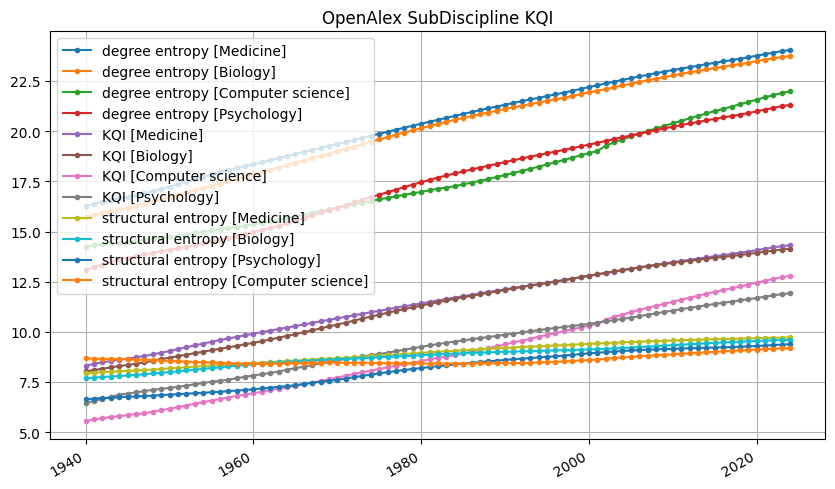

In [165]:
discipline_list = ["Medicine", "Biology", "Computer science", "Psychology"]

start_year, end_year = 1940,2024
year_range = np.arange(start_year, end_year+1, dtype=np.int16)

entropy_data_dict = collections.defaultdict(lambda :np.full(end_year-start_year+1,np.nan))
   
for doc in openalex_entropy_collection.find({ 'rankType':'current', 
                                             'endPercent':100, }):
    if isinstance(doc['entropy'],float):
        continue
    
    index = doc['year'] - start_year
    if index < 0:
        continue
    
    discipline = doc['subject']
    
    key = f"degree entropy [{discipline}]"
    entropy_data_dict[key][index] = doc['entropy']['bigdegreeentropy']
    key = f"structural entropy [{discipline}]"
    entropy_data_dict[key][index] = doc['entropy']['littlestructuralentropy']
    key = f"KQI [{discipline}]"
    entropy_data_dict[key][index] = doc['entropy']['bigdegreeentropy']- doc['entropy']['littlestructuralentropy']


df = pd.DataFrame(entropy_data_dict, index=year_range)
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]

# plt.figure(figsize=(22, 10))  # 宽度为 10 英寸，高度为 6 英寸
df.plot(marker=".",figsize=(10, 6))
# plt.xlim(start_year, end_year)
plt.title("OpenAlex SubDiscipline KQI")
# plt.xticks(year_range)
plt.grid()
plt.gcf().autofmt_xdate()
plt.show()

In [166]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "OpenAlex SubDiscipline",
                "OpenAlex In-Degree SubDiscipline KQI",
                "Year",
                "Entropy", y_axis_options = {'num_format': '#,##0','min':5, 'minor_unit':1},
                )

# distance entropy complexy

## wikipedia
用 点距离替代学科边计算的 distance complexity

In [167]:
database_name = f"wikipedia_dump_v{env_config['WIKI_VERSION']}"
wikipedia_entropy_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name]["new_distance_complexity"]
wikipedia_entropy_collection.count_documents({})

63

In [168]:
start_year, end_year = 2004,2024
year_range = np.arange(start_year, end_year+1, dtype=np.int16)

BIG_ENTROPY_KEY = "one-dimensional structural information (distance)"
LITTLE_ENTROPY_KEY = "two-dimensional structural information (distance)"


complexity_data = {
    BIG_ENTROPY_KEY:np.full(end_year-start_year+1,np.nan),
    LITTLE_ENTROPY_KEY:np.full(end_year-start_year+1,np.nan),
    # 'delta':np.full(end_year-start_year+1,np.nan)
}

module_complexity = collections.defaultdict(lambda :np.full(end_year-start_year+1,np.nan))
module_edge_stats = collections.defaultdict(lambda :np.full(end_year-start_year+1,np.nan))
module_node_stats = collections.defaultdict(lambda :np.full(end_year-start_year+1,np.nan))
module_edge_div_node_stats = collections.defaultdict(lambda :np.full(end_year-start_year+1,np.nan))

lv = 3
for doc in wikipedia_entropy_collection.find({'level':lv}):
    index = doc['year'] - start_year
    if index <= 0:
        continue
    complexity_data[LITTLE_ENTROPY_KEY][index] = doc['complexity']['littlcomplexity']    
    complexity_data[BIG_ENTROPY_KEY][index] = doc['complexity']['bigcomplexity']
    for title, value in doc['complexity']['modulecomplexity'].items():
        if value >0:
            module_complexity[title][index] = value
            
    for title, value in doc['complexity']['modulenodesize'].items():
        module_node_stats[title][index] = value
        module_edge_stats[title][index] = doc['complexity']['moduleedgecount'][title]
        module_edge_div_node_stats[title][index] = doc['complexity']['moduleedgecount'][title]/value

complexity_data['KQI'] = complexity_data[BIG_ENTROPY_KEY] - complexity_data[LITTLE_ENTROPY_KEY]

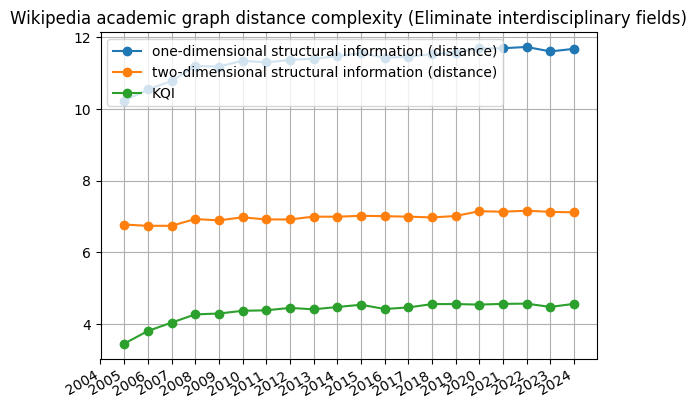

In [169]:

df = pd.DataFrame(complexity_data, index=year_range)
df.plot( marker='o')
# plt.xlim(start_year, end_year)
plt.title("Wikipedia academic graph distance complexity (Eliminate interdisciplinary fields)")
plt.xticks(year_range)
plt.grid()
plt.gcf().autofmt_xdate()

In [170]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "wiki distance complexity",
                "Wikipedia academic graph distance complexity (Eliminate interdisciplinary fields)",
                "Year",
                "Complexity", y_axis_options = {'num_format': '#,##0','min':2, 'minor_unit':1},
                )

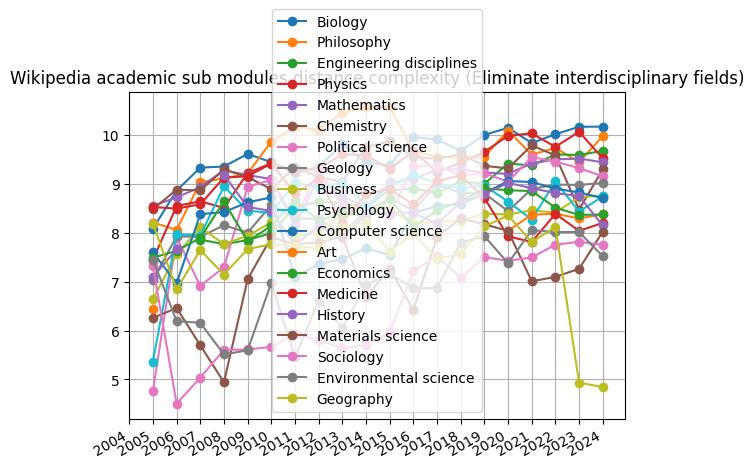

In [171]:

df = pd.DataFrame(module_complexity, index=year_range)
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
df.plot( marker='o')
# plt.xlim(start_year, end_year)
plt.title("Wikipedia academic sub modules distance complexity (Eliminate interdisciplinary fields)")
plt.xticks(year_range)
plt.grid()
plt.gcf().autofmt_xdate()

In [172]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "wiki subModules dc",
                "Wikipedia academic sub modules distance complexity (Eliminate interdisciplinary fields)",
                "Year",
                "Complexity", y_axis_options = {'num_format': '#,##0','min':4, 'minor_unit':1},
                )

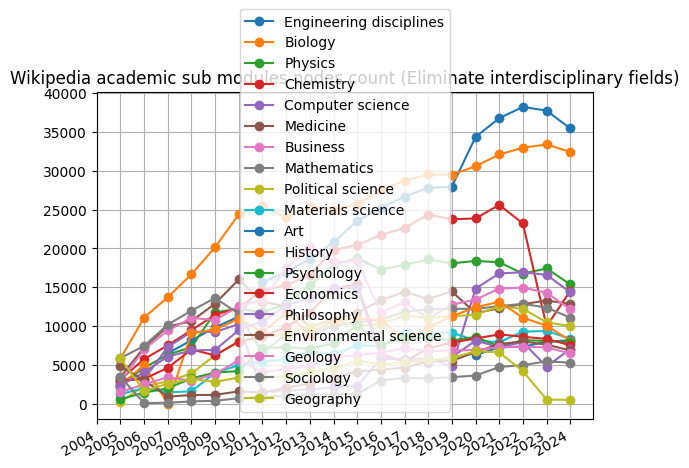

In [173]:

df = pd.DataFrame(module_node_stats, index=year_range)
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
df.plot( marker='o')
# plt.xlim(start_year, end_year)
plt.title("Wikipedia academic sub modules nodes count (Eliminate interdisciplinary fields)")
plt.xticks(year_range)
plt.grid()
plt.gcf().autofmt_xdate()

In [174]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "wiki submodules node count",
                "Wikipedia academic sub modules node count (Eliminate interdisciplinary fields)",
                "Year",
                "count", y_axis_options = {'num_format': '#,##0','min':0, 'minor_unit':1},
                )

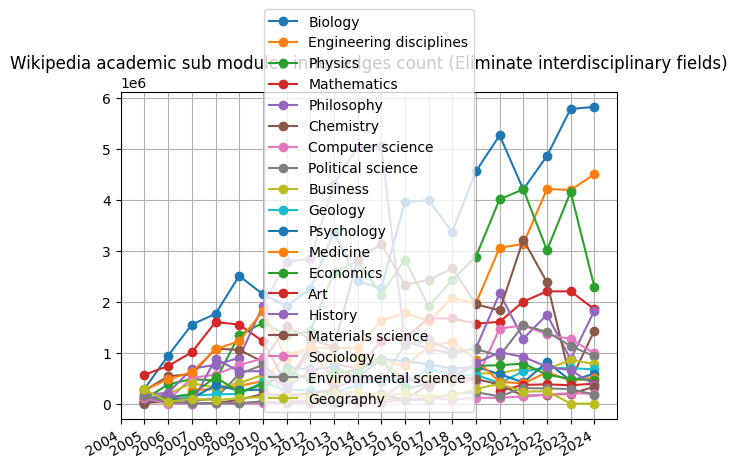

In [175]:

df = pd.DataFrame(module_edge_stats, index=year_range)
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
df.plot( marker='o')
# plt.xlim(start_year, end_year)
plt.title("Wikipedia academic sub modules inner edges count (Eliminate interdisciplinary fields)")
plt.xticks(year_range)
plt.grid()
plt.gcf().autofmt_xdate()

In [176]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "wiki submode edge count",
                "Wikipedia academic sub modules edges count (Eliminate interdisciplinary fields)",
                "Year",
                "count", y_axis_options = {'num_format': '#,##0','min':0, 'minor_unit':1},
                )

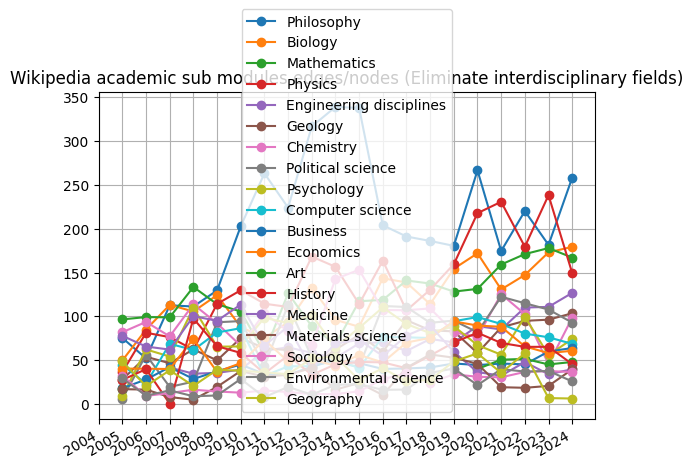

In [177]:

df = pd.DataFrame(module_edge_div_node_stats, index=year_range)
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
df.plot( marker='o')
# plt.xlim(start_year, end_year)
plt.title("Wikipedia academic sub modules edges/nodes (Eliminate interdisciplinary fields)")
plt.xticks(year_range)
plt.grid()
plt.gcf().autofmt_xdate()

In [178]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "wiki submodules edge div node",
                "Wikipedia academic sub moddules edge/node (Eliminate interdisciplinary fields)",
                "Year",
                "count", y_axis_options = {'num_format': '#,##0','min':0, 'minor_unit':1},
                )

# OpenAlex distance complexity

In [179]:
database_name = f"openalex_v{env_config['OPENALEX_VERSION']}"
openalex_entropy_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name]["new_distance_complexity"]
openalex_entropy_collection.count_documents({})

39

In [180]:
start_year, end_year = 1950,2024
year_range = np.arange(start_year, end_year+1, dtype=np.int16)

BIG_ENTROPY_KEY = "one-dimensional structural information (distance)"
LITTLE_ENTROPY_KEY = "two-dimensional structural information (distance)"

complexity_data = {
    BIG_ENTROPY_KEY:np.full(end_year-start_year+1,np.nan),
    LITTLE_ENTROPY_KEY:np.full(end_year-start_year+1,np.nan),
    # 'delta':np.full(end_year-start_year+1,np.nan)
}

module_complexity = collections.defaultdict(lambda :np.full(end_year-start_year+1,np.nan))
module_edge_stats = collections.defaultdict(lambda :np.full(end_year-start_year+1,np.nan))
module_node_stats = collections.defaultdict(lambda :np.full(end_year-start_year+1,np.nan))
module_edge_div_node_stats = collections.defaultdict(lambda :np.full(end_year-start_year+1,np.nan))

lv = 3
for doc in openalex_entropy_collection.find():
    index = doc['year'] - start_year
    if index < 0:
        continue
    complexity_data[LITTLE_ENTROPY_KEY][index] = doc['complexity']['littlcomplexity']    
    complexity_data[BIG_ENTROPY_KEY][index] = doc['complexity']['bigcomplexity']
    for title, value in doc['complexity']['modulecomplexity'].items():
        if value >0:
            module_complexity[title][index] = value
            
    for title, value in doc['complexity']['modulenodesize'].items():
        module_node_stats[title][index] = value
        module_edge_stats[title][index] = doc['complexity']['moduleedgecount'][title]
        module_edge_div_node_stats[title][index] = doc['complexity']['moduleedgecount'][title]/value

complexity_data['KQI'] = complexity_data[BIG_ENTROPY_KEY] - complexity_data[LITTLE_ENTROPY_KEY]

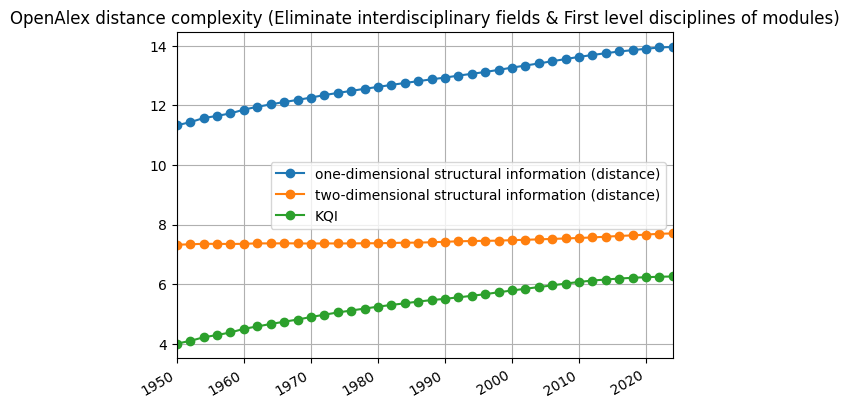

In [181]:

df = pd.DataFrame(complexity_data, index=year_range)
df = df.dropna()
df.plot( marker='o')
plt.xlim(start_year, end_year)
plt.title("OpenAlex distance complexity (Eliminate interdisciplinary fields & First level disciplines of modules)")
plt.grid()
plt.gcf().autofmt_xdate()

In [182]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "OP distance complexity",
                "OpenAlex distance complexity (Eliminate interdisciplinary fields & First level disciplines of modules)",
                "Year",
                "Complexity", y_axis_options = {'num_format': '#,##0','min':2, 'minor_unit':1},
                )

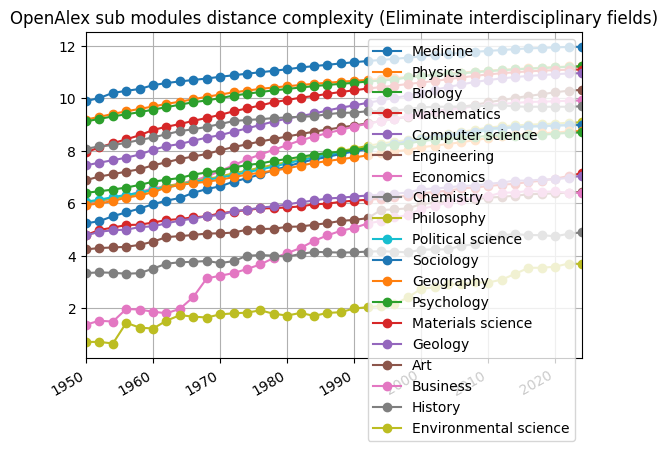

In [183]:

df = pd.DataFrame(module_complexity, index=year_range)

df = df.dropna()
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
df.plot( marker='o')
plt.xlim(start_year, end_year)
plt.title("OpenAlex sub modules distance complexity (Eliminate interdisciplinary fields)")
# plt.xticks(year_range)
plt.grid()
plt.gcf().autofmt_xdate()

In [184]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "OpenAlex subModules dc",
                "OpenAlex sub modules distance complexity (Eliminate interdisciplinary fields)",
                "Year",
                "Complexity", y_axis_options = {'num_format': '#,##0','min':4, 'minor_unit':1},
                )

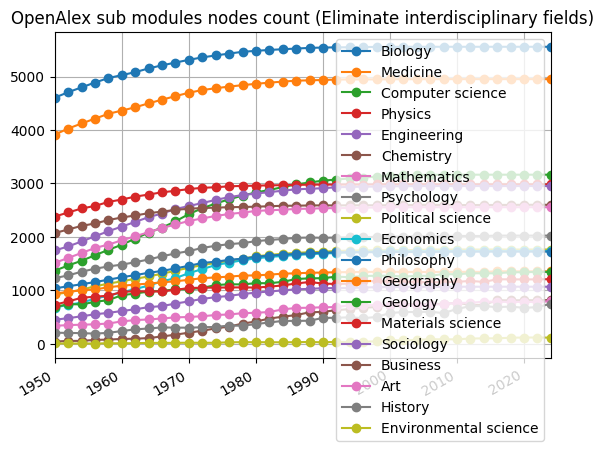

In [185]:

df = pd.DataFrame(module_node_stats, index=year_range)
df = df.dropna()
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
df.plot( marker='o')
plt.xlim(start_year, end_year)
plt.title("OpenAlex sub modules nodes count (Eliminate interdisciplinary fields)")
# plt.xticks(year_range)
plt.grid()
plt.gcf().autofmt_xdate()

In [186]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "OP submodules node count",
                "OpenAlex sub modules node count (Eliminate interdisciplinary fields)",
                "Year",
                "count", y_axis_options = {'num_format': '#,##0','min':0, 'minor_unit':1},
                )

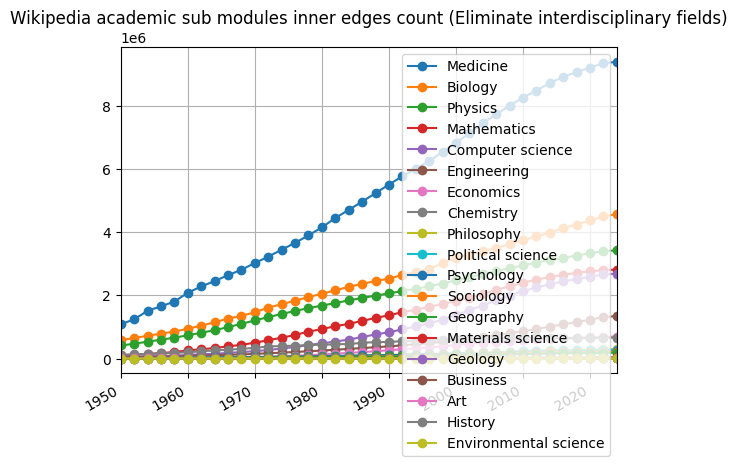

In [187]:

df = pd.DataFrame(module_edge_stats, index=year_range)
df = df.dropna()
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
df.plot( marker='o')
plt.xlim(start_year, end_year)
plt.title("Wikipedia academic sub modules inner edges count (Eliminate interdisciplinary fields)")
# plt.xticks(year_range)
plt.grid()
plt.gcf().autofmt_xdate()

In [188]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "OP submode edge count",
                "OpenAlex sub modules edges count (Eliminate interdisciplinary fields)",
                "Year",
                "count", y_axis_options = {'num_format': '#,##0','min':0, 'minor_unit':1},
                )

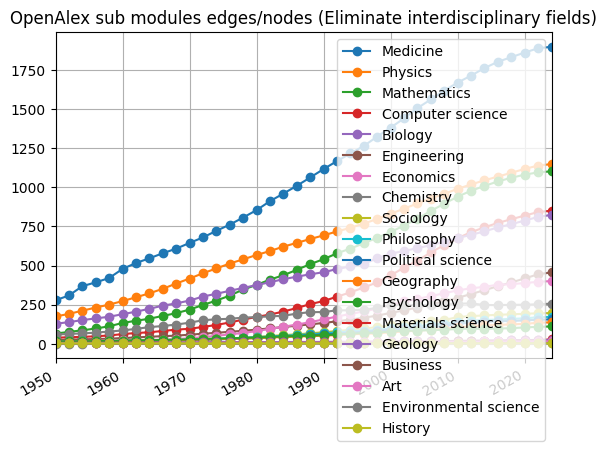

In [189]:

df = pd.DataFrame(module_edge_div_node_stats, index=year_range)
df = df.dropna()
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
df.plot( marker='o')
plt.xlim(start_year, end_year)
plt.title("OpenAlex sub modules edges/nodes (Eliminate interdisciplinary fields)")
# plt.xticks(year_range)
plt.grid()
plt.gcf().autofmt_xdate()

In [190]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "OP submodules edge div node",
                "OpenAlex sub moddules edge/node (Eliminate interdisciplinary fields)",
                "Year",
                "count", y_axis_options = {'num_format': '#,##0','min':0, 'minor_unit':1},
                )

# OpenAlex 顶级学科 distance complexity

In [191]:
database_name = f"openalex_v{env_config['OPENALEX_VERSION']}"
openalex_entropy_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name]["top_discipline_distance_complexity"]
openalex_entropy_collection.count_documents({})

760

In [206]:
start_year, end_year = 1950,2024
year_range = np.arange(start_year, end_year+1, dtype=np.int16)

BIG_ENTROPY_KEY = "one-dimensional structural information (distance)"
LITTLE_ENTROPY_KEY = "two-dimensional structural information (distance)"

disciplines_complexity_data = collections.defaultdict(
    lambda:{
        BIG_ENTROPY_KEY:np.full(end_year-start_year+1,np.nan),
        LITTLE_ENTROPY_KEY:np.full(end_year-start_year+1,np.nan),
    }
)

discipline_module_complexity = collections.defaultdict(
    lambda:collections.defaultdict(lambda :np.full(end_year-start_year+1,np.nan))
)
discipline_module_edge_stats = collections.defaultdict(
    lambda:collections.defaultdict(lambda :np.full(end_year-start_year+1,np.nan))
)
discipline_module_node_stats = collections.defaultdict(
    lambda:collections.defaultdict(lambda :np.full(end_year-start_year+1,np.nan))
)
discipline_module_edge_div_node_stats = collections.defaultdict(
    lambda:collections.defaultdict(lambda :np.full(end_year-start_year+1,np.nan))
)
discipline_module_counts = collections.defaultdict(
    lambda:np.full(end_year-start_year+1,np.nan)
)

for doc in openalex_entropy_collection.find():
    index = doc['year'] - start_year
    if index < 0:
        continue
    
    # todo fix
    discipline = doc['discipline']
    
    # debug 元数据有2风，其中一份较小的数数据错误
    if doc['complexity']['bigcomplexity'] <disciplines_complexity_data[discipline][BIG_ENTROPY_KEY][index]:
        continue
    disciplines_complexity_data[discipline][LITTLE_ENTROPY_KEY][index] = doc['complexity']['littlcomplexity']    
    disciplines_complexity_data[discipline][BIG_ENTROPY_KEY][index] = doc['complexity']['bigcomplexity']
    
    discipline_module_counts[discipline][index] = len(doc['complexity']['modulecomplexity'])
    for title, value in doc['complexity']['modulecomplexity'].items():
        if value > 0:
            discipline_module_complexity[discipline][title][index] = value
            
    for title, value in doc['complexity']['modulenodesize'].items():
        discipline_module_node_stats[discipline][title][index] = value
        discipline_module_edge_stats[discipline][title][index] = doc['complexity']['moduleedgecount'][title]
        discipline_module_edge_div_node_stats[discipline][title][index] = doc['complexity']['moduleedgecount'][title]/value

for key in disciplines_complexity_data.keys():
    disciplines_complexity_data[key]['KQI'] = disciplines_complexity_data[key][BIG_ENTROPY_KEY] - disciplines_complexity_data[key][LITTLE_ENTROPY_KEY]

In [193]:
# merge by discipline

# BIG_ENTROPY_KEY
big_discipline_complexity = {}
little_discipline_complexity = {}
kqi_discipline_complexity = {}
for discipline_title, data in disciplines_complexity_data.items():
    big_discipline_complexity[discipline_title] = data[BIG_ENTROPY_KEY]
    little_discipline_complexity[discipline_title] = data[LITTLE_ENTROPY_KEY]
    kqi_discipline_complexity[discipline_title] = data["KQI"]


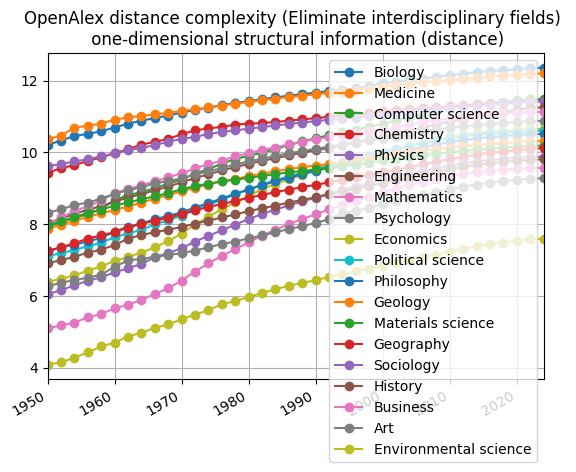

In [194]:

df = pd.DataFrame(big_discipline_complexity, index=year_range)
df = df.dropna()
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
df.plot( marker='o')
plt.xlim(start_year, end_year)
plt.title(f"OpenAlex distance complexity (Eliminate interdisciplinary fields) \n {BIG_ENTROPY_KEY}")
plt.grid()
plt.gcf().autofmt_xdate()

In [195]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "OA topDis One-Dim",
                f"OpenAlex distance complexity (Eliminate interdisciplinary fields) \n {BIG_ENTROPY_KEY}",
                "Year",
                "Complexity", y_axis_options = {'num_format': '#,##0','min':4, 'minor_unit':1},
                )

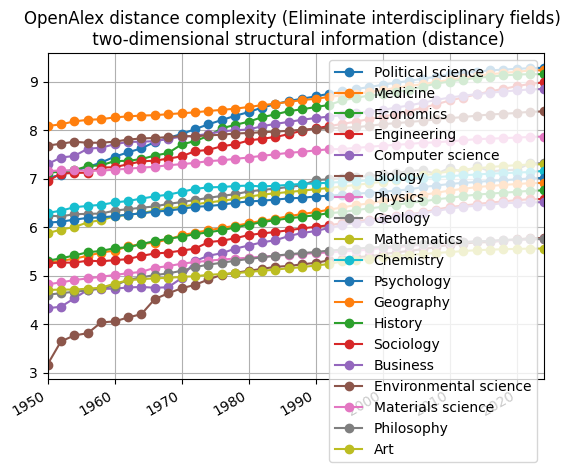

In [196]:

df = pd.DataFrame(little_discipline_complexity, index=year_range)
df = df.dropna()
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
df.plot( marker='o')
plt.xlim(start_year, end_year)
plt.title(f"OpenAlex distance complexity (Eliminate interdisciplinary fields) \n {LITTLE_ENTROPY_KEY}")
plt.grid()
plt.gcf().autofmt_xdate()

In [197]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "OA topDis Two-Dim",
                f"OpenAlex distance complexity (Eliminate interdisciplinary fields) \n {LITTLE_ENTROPY_KEY}",
                "Year",
                "Complexity", y_axis_options = {'num_format': '#,##0','min':4, 'minor_unit':1},
                )

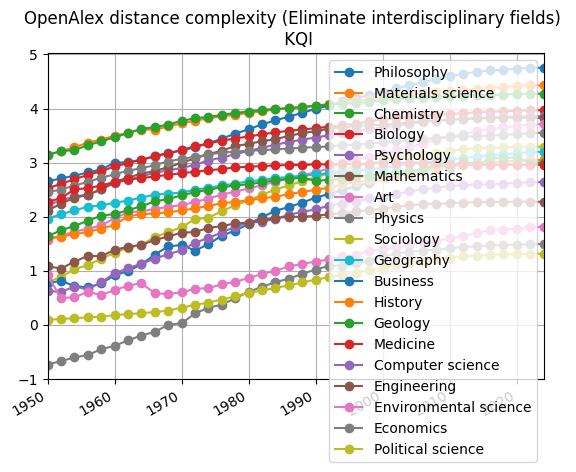

In [198]:

df = pd.DataFrame(kqi_discipline_complexity, index=year_range)
df = df.dropna()
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
df.plot( marker='o')
plt.xlim(start_year, end_year)
plt.title(f"OpenAlex distance complexity (Eliminate interdisciplinary fields) \n KQI")
plt.grid()
plt.gcf().autofmt_xdate()

In [199]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "OA topDis KQI",
                f"OpenAlex distance complexity (Eliminate interdisciplinary fields) \n KQI",
                "Year",
                "KQI", y_axis_options = {'num_format': '#,##0','min':-1, 'minor_unit':1},
                )

In [201]:
XLSX_WRITER.close()

In [ ]:
# 统计模块数量

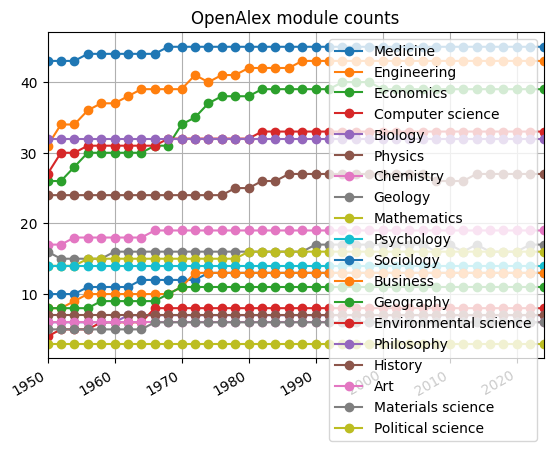

In [211]:
# 各个学科的模块数量
# merge by discipline

# BIG_ENTROPY_KEY
# big_discipline_complexity = {}
# little_discipline_complexity = {}
# kqi_discipline_complexity = {}
# for discipline_title, data in disciplines_complexity_data.items():
#     big_discipline_complexity[discipline_title] = data[BIG_ENTROPY_KEY]
#     little_discipline_complexity[discipline_title] = data[LITTLE_ENTROPY_KEY]
#     kqi_discipline_complexity[discipline_title] = data["KQI"]
    
    
df = pd.DataFrame(discipline_module_counts, index=year_range)
df = df.dropna()
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
df.plot( marker='o')
plt.xlim(start_year, end_year)
plt.title(f"OpenAlex module counts")
plt.grid()
plt.gcf().autofmt_xdate()


In [269]:
XLSX_WRITER = pd.ExcelWriter('openalex_lv2_modules_stats.xlsx', engine="xlsxwriter")


In [270]:
    
df = pd.DataFrame(discipline_module_counts, index=year_range)
df = df.dropna()
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "OA module counts",
                f"OpenAlex module counts",
                "Year",
                "Count", y_axis_options = {'num_format': '#,##0','min':0, 'minor_unit':1},
                )

In [271]:

for modules_title, complexity_data in discipline_module_complexity.items():
    df = pd.DataFrame(complexity_data, index=year_range)
    df = df.dropna(how="all")
    df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
    # df.plot( marker='o')
    # plt.xlim(start_year, end_year)
    # plt.title(f"OpenAlex {modules_title} distance complexity")
    # plt.grid()
    # plt.gcf().autofmt_xdate()
    
    draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                f"OA {modules_title} dc",
                f"OpenAlex {modules_title} distance complexity",
                "Year",
                "Complexity", y_axis_options = {'num_format': '#,##0','min':0, 'minor_unit':1},
                )
    
    # break

/tmp/ipykernel_2273996/2581722170.py:4: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  df = df[df.columns[df.iloc[-1].argsort()[::-1]]]


In [272]:

for modules_title, stats_data in discipline_module_node_stats.items():
    df = pd.DataFrame(stats_data, index=year_range)
    df = df.dropna(how="all")
    df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
    # df.plot( marker='o')
    # plt.xlim(start_year, end_year)
    # plt.title(f"OpenAlex {modules_title} distance complexity")
    # plt.grid()
    # plt.gcf().autofmt_xdate()
    
    draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                f"OA {modules_title} nc",
                f"OpenAlex {modules_title} module node counts",
                "Year",
                "Count", y_axis_options = {'num_format': '#,##0','min':0, 'minor_unit':1},
                )
    
    # break

/tmp/ipykernel_2273996/1027232094.py:4: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  df = df[df.columns[df.iloc[-1].argsort()[::-1]]]


In [273]:

for modules_title, stats_data in discipline_module_edge_stats.items():
    df = pd.DataFrame(stats_data, index=year_range)
    df = df.dropna(how="all")
    df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
    # df.plot( marker='o')
    # plt.xlim(start_year, end_year)
    # plt.title(f"OpenAlex {modules_title} distance complexity")
    # plt.grid()
    # plt.gcf().autofmt_xdate()
    
    draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                f"OA {modules_title} ec",
                f"OpenAlex {modules_title} module edge counts",
                "Year",
                "Count", y_axis_options = {'num_format': '#,##0','min':0, 'minor_unit':1},
                )
    
    # break

/tmp/ipykernel_2273996/2032407238.py:4: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  df = df[df.columns[df.iloc[-1].argsort()[::-1]]]


In [274]:

for modules_title, stats_data in discipline_module_edge_div_node_stats.items():
    df = pd.DataFrame(stats_data, index=year_range)
    df = df.dropna(how="all")
    df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
    # df.plot( marker='o')
    # plt.xlim(start_year, end_year)
    # plt.title(f"OpenAlex {modules_title} distance complexity")
    # plt.grid()
    # plt.gcf().autofmt_xdate()
    
    draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                f"OA {modules_title} edn",
                f"OpenAlex {modules_title} module edge div counts",
                "Year",
                "Proportion", y_axis_options = {'num_format': '#,##0','min':0, 'minor_unit':1},
                )
    
    # break

/tmp/ipykernel_2273996/4267416850.py:4: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  df = df[df.columns[df.iloc[-1].argsort()[::-1]]]


In [275]:
XLSX_WRITER.close()